In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.nn import functional as F
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset

import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(42)
if torch.cuda.is_available():
  torch.cuda.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

import tiktoken
enc = tiktoken.get_encoding("gpt2")

import re

cuda


build a gpt model from scratch using transfoer architecture

sincos position ambedding

multi head attetnion with flash attetnion and autoregressive behaviour

decoder only transfoer

swiglu activation function

rmsnorm

learning_rate_sheduler

mixed precision (bfloat16)

MoE

logging teh metrics like loss etc

preplixity or bert score for evaluation



In [18]:
from dataclasses import dataclass
@dataclass
class GPTParameters:
  d_model:int = 256 # embedding dimension
  block_size:int = 128 # context length
  batch_size:int = 12  # batch_size
  vocab_size:int = enc.n_vocab  # vocab size of tiktoken
  n_heads:int = 4  # 256/4 = 64
  n_layers:int = 6
  max_len:int = 128   # must match block_size
  dropout:float = 0.2

# class GPTParameters:
#   d_model:int = 8 # embedding dimension
#   block_size:int = 8 # context length
#   batch_size:int = 4  # batch_size
#   vocab_size:int = enc.n_vocab  # vocab size of tiktoken
#   n_heads:int = 2  # 8/2 = 4
#   n_layers:int = 2
#   max_len:int = 8  # must match block_size
#   dropout:float = 0.25


with open("combine.txt" ,"r") as f:
  data = f.read()

tokens = enc.encode(data)
print("Total no of Tokens :",len(tokens))

Total no of Tokens : 2790391


# Custom dataloader class(Faster)

In [19]:
tokens = enc.encode(data)  # encode the dataset  ==> It is 1D we need to conver it to 2D
tokens_tensor = torch.tensor(tokens,dtype=torch.long) # convert the tokens to tensor

n = int(0.9 * len(tokens_tensor))
train = tokens_tensor[:n]  # first 90% for training
val = tokens_tensor[n:]  # reaming 10% for validation


class DataLoaderLite:
  def __init__(self,config,data):
    self.data = data
    self.block_size = config.block_size
    self.batch_size = config.batch_size

  def get_batch(self):
    """
    Random Sampling:
    For every training step, we randomly pick starting positions from the data.
    Suppose our data has 10,000 tokens and we want 4 sequences per batch
      len(self.data) = 10000
		  block_size = 256
			batch_size = 4
      output of torch.randint ==> tensor([876, 4921, 7321, 193])
    """
    # Step 1: Random Sampling(every time we run this get_batch() function we will ranomly chose x and y from this samples)
    ix = torch.randint(len(self.data) - self.block_size,(self.batch_size,))

    # Step 2: x(input)
    x = torch.stack([self.data[i:i+self.block_size] for i in ix]) # [1,2,3,4,5,6]

    # Step 3: y(target)
    y = torch.stack([self.data[i+1:i+1+self.block_size] for i in ix]) # [2,3,4,5,6,7]

    if device == "cuda":
      x = x.pin_memory()
      y = y.pin_memory()

    return x.to(device,non_blocking=True),y.to(device,non_blocking=True)


config_param= GPTParameters()
train_data =  DataLoaderLite(data=train,
                             config = config_param)
val_data = DataLoaderLite(data=val,
                          config=config_param)

# PyTorch performs matrix multiplications
# Whenever you do matrix multiplications in float32 (e.g., attention layers, linear layers), use TF32 if available.
torch.set_float32_matmul_precision("high")
print("TF32 enabled:", torch.backends.cuda.matmul.allow_tf32)
print("BF16 supported:", torch.cuda.is_bf16_supported())
print("FP16 supported:", torch.cuda.is_available())

train_data.get_batch()


TF32 enabled: True
BF16 supported: True
FP16 supported: True


(tensor([[21647,   286, 38167,  ...,   262, 12389,   764],
         [  262,   886,   837,  ...,  4624,  6333,  2488],
         [ 3300,  2516, 10711,  ...,   876,   318,   257],
         ...,
         [  635,  4987,   351,  ...,    72, 16746,   366],
         [  290,   373, 11038,  ...,  1719, 10010,  1437],
         [15984,   468,  6150,  ..., 20733,  6866,  1872]], device='cuda:0'),
 tensor([[  286, 38167,   784,  ..., 12389,   764,   770],
         [  886,   837,   262,  ...,  6333,  2488,    12],
         [ 2516, 10711,  5254,  ...,   318,   257, 41314],
         ...,
         [ 4987,   351,   837,  ..., 16746,   366,   764],
         [  373, 11038,   416,  ..., 10010,  1437, 21755],
         [  468,  6150,  4632,  ...,  6866,  1872,  3972]], device='cuda:0'))

# Pytorch DataLoader class

In [ ]:
tokens = enc.encode(data)  # encode the dataset  ==> It is 1D we need to conver it to 2D
tokens_tensor = torch.tensor(tokens,dtype=torch.long) # convert the tokens to tensor

n = int(0.9 * len(tokens_tensor))
train = tokens_tensor[:n]  # first 90% for training
val = tokens_tensor[n:]  # reaming 10% for validation


class GPTDataClass(Dataset):

  def __init__(self,config,tokens):
    self.tokens = tokens
    self.block_size = config.block_size

  def __len__(self):
    return len(self.tokens) - self.block_size

  def __getitem__(self,idx):
    x = self.tokens[idx:idx+self.block_size]
    y = self.tokens[idx+1:idx+1+self.block_size]
    return x,y

config = GPTParameters()
train_dataset = GPTDataClass(config,train)
val_dataset = GPTDataClass(config,val)

train_loader = DataLoader(train_dataset,
                          pin_memory=True,
                          num_workers=2,
                          shuffle=True,
                          batch_size=config.batch_size)


val_loader = DataLoader(val_dataset,
              pin_memory=True,
              shuffle=False,
              batch_size = config.batch_size)


for x,y in train_loader:
  print(x)
  print("="*100)
  print(y)
  break


# default is highest(float32) ==> high(tensorfloat32)
# "highest"  ==> FP32   # Full precision(fp32) (slowest, most accurate)
# "high"     ==> TF32   # TensorFloat32 (fast, slightly less accurate)
# "medium"   ==> FP16 / BF16 mixed  # Fastest, lowest precision
# PyTorch performs matrix multiplications
# Whenever you do matrix multiplications in float32 (e.g., attention layers, linear layers), use TF32 if available.
torch.set_float32_matmul_precision("high")

print("TF32 enabled:", torch.backends.cuda.matmul.allow_tf32)
print("BF16 supported:", torch.cuda.is_bf16_supported())
print("FP16 supported:", torch.cuda.is_available())

tensor([[10890,    11,   763,    12, 20123,   425,  1429,  1022],
        [ 5386, 15387,   290, 11257,    13,   257,    72,    12],
        [   13,    17,   220,   220,   220,   220,   220,   220],
        [28127,   803,   290, 20796, 32660,    76,  7351, 31108]])
tensor([[   11,   763,    12, 20123,   425,  1429,  1022,  1692],
        [15387,   290, 11257,    13,   257,    72,    12, 15808],
        [   17,   220,   220,   220,   220,   220,   220,   220],
        [  803,   290, 20796, 32660,    76,  7351, 31108,    13]])
TF32 enabled: True
BF16 supported: False
FP16 supported: False


In [21]:
import math
# Multi Head Attetnion

 #============================================================== MultiHeadAttention ==================================================

class MultiHeadAttetnion(nn.Module):
  def __init__(self,config):
    super().__init__()
    assert config.d_model % config.n_heads == 0,"Head is not divisible by embedding dimesnion chose differnt head value"
    self.att = nn.Linear(config.d_model,3*config.d_model) # linear layer to generate Q,K and V
    self.att_proj = nn.Linear(config.d_model,config.d_model) # projection layer for Q,K and V
    self.n_heads = config.n_heads
    self.d_model = config.d_model
    self.d_heads = config.d_model // config.n_heads
    # this create masked once during initlization more effiecnet compare to creating maske on every forward pass
    self.register_buffer("bias",torch.tril(torch.ones(config.block_size,config.block_size)).view(1,1,config.block_size,config.block_size)) #(B,n_head,T,T)

  def forward(self,x,flash_attention=False):
    B,T,C = x.shape #(B,T,C)  input

    qkv = self.att(x) # Generate Q,K and V vector ==>(B,T,3*C)
    # torch.Tensor.split(split_size, dim)
    q,k,v = qkv.split(self.d_model,dim=2)

    q = q.view(B,T,self.n_heads,self.d_heads).transpose(1,2) # (B,T,C) ===> (B,T,n_head,d_head) ===> (B,n_head,T,d_head)
    k = k.view(B,T,self.n_heads,self.d_heads).transpose(1,2) # (B,T,C) ===> (B,T,n_head,d_head) ===> (B,n_head,T,d_head)
    v = v.view(B,T,self.n_heads,self.d_heads).transpose(1,2) # (B,T,C) ===> (B,T,n_head,d_head) ===> (B,n_head,T,d_head)

    # FLASH ATTENTION
    if flash_attention:
      y = torch.nn.functional.scaled_dot_product_attention(q,k,v,
                                attn_mask=None, # for padding (encoder)
                                dropout_p = 0.1,
                                is_causal=True # for masking(autoregressive)
                              ) # ==> (B, n_head, T, d_head)     ==>flash attention compute attetnion in fused cuda kernel so we can not view attetnion plots
    else:
      # attetnion score
      att = q @ k.transpose(-2,-1) * (1.0/math.sqrt(k.size(-1)))

      # maks attention ==> token attetnd to only previous token and not the future tokens
      att = att.mask_fill(self.bias[:,:,:T,:T]==0, float("-inf")) # (B,n_head,T,T)

      att = F.softmax(att,dim=-1) # apply softmax on last dimension(C)

      # attetnion weight
      y = att @ v # (B,n_head,T,T) x (B,n_head,T,d_head) ===> (B,n_head,T,d_head)


    # Re assemble all head output side by side
    # C = n_head * d_head
    y = y.transpose(1,2).contiguous().view(B,T,C)

    # Output projection
    y = self.att_proj(y)

    return y

# ============================================================== Positional ENcoding ===================================================================

class PositionalEncoding(nn.Module):
  """
  Formulas:
    PE(pos, 2i) = sin(pos / 10000^(2i/d_model))
    PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))
  where:
    - pos is the position in the sequence
    - i is the dimension index
    - d_model is the embedding dimension
  """
  def __init__(self,config):
    """
    Args:
      max_len (int): maximum sequence length
      d_model (int): embedding dimension
    """
    super().__init__()

    # step 1 : # Create positional encoding matrix
    pe = torch.zeros(config.max_len,config.d_model)
    position = torch.arange(0,config.max_len,dtype=torch.float).unsqueeze(1) # ==> (max_len,d_model)

    # step 2: Calculate the division term: 10000^(2i/d_model)
    div_term = torch.exp(torch.arange(0,config.d_model,2).float() * -(math.log(10000.0/config.d_model)))

    # step 3: Apply sin to even indices cos to odd indices
    pe[:,0::2] = torch.sin(position * div_term)
    pe[:,1::2] = torch.cos(position * div_term)

    # Add batch dimension: (max_len, d_model) ==> (1, max_len, d_model)
    pe = pe.unsqueeze(0)

    # register buffer so its not a parameter
    self.register_buffer("pe",pe)

  def forward(self,x):
    B,T,C = x.shape
    x = x + self.pe[:,:T,:]
    return x

# ====================================================================== RMSNorm ================================================

class RMSNorm(nn.Module):
  def __init__(self,config,eps=1e-8):
    super().__init__()
    self.eps = eps
    self.weights = nn.Parameter(torch.ones(config.d_model)) # # each feature dimension gets a learnable scaling factor.

  def forward(self,x):
    x = x.float()  # to calculate mean x has to be floating point no
    rms = torch.sqrt(x.pow(2).mean(dim=-1,keepdim=True) + self.eps)
    return (x/rms) * self.weights


# ======================================================= SwiGLU Activation Function ================================================

class SwiGLU(nn.Module):
  """

	  x ──► W1 ─────────────|
							element-wise multiply ──► W3 ──► output
	  x ──► W2 ──► Swish ──┘

  """
  def __init__(self,config):
    super().__init__()
    inner = config.d_model * 4
    self.w1 = nn.Linear(config.d_model,inner,bias=False)  # main path
    self.w2 = nn.Linear(config.d_model,inner,bias=False)  # gate path with swish activation function
    self.w3 = nn.Linear(inner,config.d_model,bias=False)  # projection layer
    self.act = nn.SiLU()
    self.dropout = nn.Dropout(config.dropout)

  def forward(self,x):
    a = self.w1(x)  # main path
    b  = self.act(self.w2(x))  # gate path with activation swish activation function
    y = a * b  # elemnet wise multiplication
    out = self.w3(y) # projection layer
    return self.dropout(out)


# ========================================================== FFNN ================================================

class FFNN(nn.Module):
  def __init__(self,config):
    """
    SwiGLU is a complete replacement for the standard Linear→ReLU→Linear pattern.
    """
    super().__init__()
    self.network = nn.Sequential(
        SwiGLU(config),  # non-linearity
        nn.Dropout(config.dropout)
    )

  def forward(self,x):
    x = self.network(x)
    return x

# ============================================================ Decoder Internall Block ==================================================

class Block(nn.Module):
  def __init__(self,config):
    super().__init__()
    self.ln1 = RMSNorm(config) # pre-layer norm - 1 for attetnion block
    self.att = MultiHeadAttetnion(config) # multi head attetnion block
    self.ln2 = RMSNorm(config) # pre-layer norm - 2 for FFNN block
    self.ffn = FFNN(config)

  def forward(self,x):
    x = x + self.att(self.ln1(x),flash_attention=True)
    x = x + self.ffn(self.ln2(x))
    return x



# =============================================== GPTModle ==============================================

class MyGPTModel(nn.Module):
  def __init__(self,config):
    super().__init__()

    self.transformer = nn.ModuleDict({
        "wte":nn.Embedding(config.vocab_size,config.d_model),
        "pe":PositionalEncoding(config),
        "h":nn.ModuleList(Block(config) for _ in range(config.n_layers)),
        "ln_f":RMSNorm(config)
    })

    # linear layer after trasnfoer block
    self.lm_head = nn.Linear(config.d_model,config.vocab_size,bias=False)

    # In GPT the same weight matrix is used for both word embedding and final output layer.
    # Weight tying (share token embedding weights with output head)  save computatuion heavily
    self.lm_head.weight = self.transformer["wte"].weight


  def forward(self,x,target=None):
    B,T = x.shape  # input doesnot have C dimension as it is not yet converted to Embeddings

    # step 1: token embedding + pos embedding
    tok_emb = self.transformer["wte"](x)
    pos_emb = self.transformer["pe"](tok_emb)  # it internally add ==> tok_emb + pos_emb


    # step 2: Multi Head attention
    for block in self.transformer.h:
      x = block(pos_emb)

    x = self.transformer["ln_f"](x)


    # Get logits after final transformer layer
    logits = self.lm_head(x)  # (B,T,vocab_size)


    loss = None
    if target is not None:
      B,T,C = logits.shape  #(B,T,C)  cross entorpy ==> accept (B,C)
      logits = logits.view(B*T,C)
      target = target.view(B*T)
      loss = F.cross_entropy(logits,target)
    return logits,loss


model = MyGPTModel(config_param).to(device)
model = torch.compile(model)
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,betas=(0.9,0.95),eps=1e-8,weight_decay=0.1)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Trainable Parameters: {total_params:,}")

Total Trainable Parameters: 19,166,720


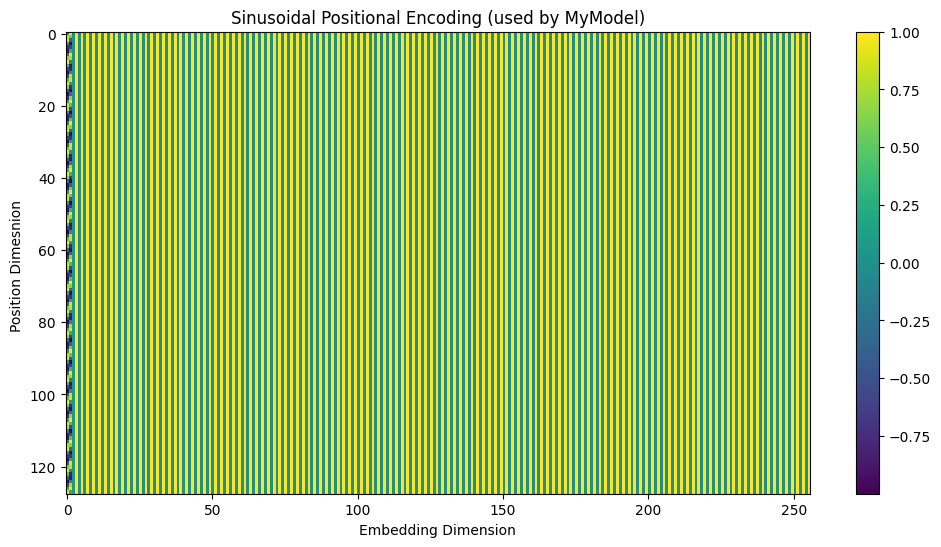

In [22]:
pe = model.transformer["pe"].pe.squeeze(0).detach().cpu()

plt.figure(figsize=(12, 6))
plt.imshow(pe,cmap="viridis",aspect="auto",interpolation="nearest")
plt.xlabel("Embedding Dimension")
plt.ylabel("Position Dimesnion ")
plt.title("Sinusoidal Positional Encoding (used by MyModel)")
plt.colorbar()
plt.show()

In [20]:
import torch
torch.cuda.empty_cache()

del model
del optimizer



# Custom Training Loop

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls /content/drive/MyDrive/GPT

checkpoint_step1000.pt	metrics.json  training_logs.txt


In [ ]:
!cp /content/drive/MyDrive/GPT/checkpoint_step1000.pt /content/
!cp /content/drive/MyDrive/GPT/metrics.json /content/
!cp /content/drive/MyDrive/GPT/training_logs.txt /content/

In [24]:
import logging
from tqdm import tqdm


num_epochs = 8
eval_interval = 1
save_interval = 1
eval_batches = 120  # number of batches to use for validation

# total_batches = total token/ tokens per batch
batches_per_epoch = len(tokens) // (config_param.batch_size * config_param.block_size) # number of batches to process per epoch   ======> len(data) // (batch_size * block_size)
# batches_per_epoch = 1
print("No of batches:",batches_per_epoch)

# ===================== Learning rate schedule ======================
max_lr = 6e-4
min_lr = max_lr * 0.1 # 10% of max lr
warmup_epochs = 2
max_epochs = num_epochs
def get_lr(t):
  """
  t:current step
  The learning rate will increase linearly and when it reaches warmup step it start to decrease using cosine decay
  """
  # 1) linear warmup(when current step is less than warmpu step we increase learning rate)
  if t < warmup_epochs:
    return max_lr * (t+1)/warmup_epochs

  # 2) Cosine Decay  ==> when it reaches warmup steps
  decay_epochs = num_epochs - warmup_epochs
  progress = (t- warmup_epochs) / decay_epochs
  cosine_lr = min_lr + 0.5 * (max_lr - min_lr) * (1 + math.cos(math.pi * progress))
  return cosine_lr


  # ================================== Eval Loss Calculation ==========================

@torch.no_grad()
def loss_calculation(data_loader,num_batches):
  model.eval()
  val_losses = []

  for _ in tqdm(range(num_batches),desc="Evaluation"):
    xb,yb = val_data.get_batch()
    if device == "cuda":
      with torch.amp.autocast():
        logits,loss = model(xb,yb)
    else:
      logits,loss = model(xb,yb)
    val_losses.append(loss.item())
  return sum(val_losses) / len(val_losses)


# =================================== Checkpoint Helper ==============================

def save_checkpoint(epoch, avg_train_loss, avg_val_loss, filename):
    """Save model checkpoint with training state"""
    checkpoint = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scaler_state_dict": scaler.state_dict(),  # Save scaler state too
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "learning_rate": learning_rate[-1] if learning_rate else 0,
        "config": {
            "max_lr": max_lr,
            "min_lr": min_lr,
            "warmup_steps": warmup_epochs,
            "max_steps": max_epochs,
            "accum_steps": accum_steps
        }
    }
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved: {filename}")



No of batches: 1816


In [25]:
import json
import logging
import time

# ===================================== Logging ======================================
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(message)s",
    handlers=[
        logging.FileHandler("training_logs.txt", mode="a")
    ],
    force=True
)


scaler = torch.cuda.amp.GradScaler() # for stable FP16 training(amp=automatic mixed percisoin)
learning_rate = []
train_loss = []
val_loss = []
epoch_times = []

accum_steps = 4
best_val_loss = float("inf")


# ========================================================= Training Loop =================================

print("Starting training...")
for epoch in range(num_epochs):
  epoch_start_time = time.time()
  total_train_loss = 0
  num_batches = 0
  model.train()

  for i in tqdm(range(batches_per_epoch),desc="training"):
    # ================================= Forward + Backward Propogation ==================================================
    xb,yb = train_data.get_batch()

    if device == "cuda":
      with torch.cuda.amp.autocast():
        logits,loss = model(xb,yb)
    else:
        logits,loss = model(xb,yb)
    loss = loss / accum_steps  # normalize the loss as (l1+l2+l3+l4)/4
    scaler.scale(loss).backward()

    total_train_loss +=loss.item() * accum_steps
    num_batches +=1  # increment batch by 1


# ============================ Gradient Accumulation Updatate ===========================================
    if (i+1) % accum_steps == 0:
      # Unscale gradients before clipping
      scaler.unscale_(optimizer)

      # Gradinet clipping
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) ## help in reducing exploding gradient issue by normalizing them

      # update parameter
      scaler.step(optimizer)
      scaler.update()
      optimizer.zero_grad(set_to_none=True)

    # Handle remaining gradient if batches dont divide evenly by accum_steps
    if num_batches % accum_steps != 0:
      scaler.unscale_(optimizer)
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) ## help in reducing exploding gradient issue by normalizing them
      scaler.step(optimizer)
      scaler.update()
      optimizer.zero_grad(set_to_none=True)

#================================ End of epoch =======================================

  # Calculate average training loss for the epoch
  avg_train_loss = total_train_loss / num_batches
  train_loss.append(avg_train_loss)

  # update learning rate per epoch
  lr = get_lr(epoch)
  for param_group in optimizer.param_groups:
    param_group["lr"] = lr
  learning_rate.append(lr)


  # calculate time per epoch
  epoch_duration = time.time() - epoch_start_time
  epoch_times.append(epoch_duration)

#=========================================== Evaluation =========================================================
  if (epoch+1) % eval_interval == 0:
    print("Evaluating.....")
    avg_val_loss = loss_calculation(val_data,eval_batches)
    val_loss.append(avg_val_loss)
    logging_msg = (f"Epoch: {epoch+1}/{num_epochs}  |  "
                        f"train_loss: {avg_train_loss:.4f}  |  "
                        f"val_loss: {avg_val_loss:.4f}  |  "
                        f"lr: {lr:.6f}  |  "
                        f"time: {epoch_duration/60:.2f}m")
    logging.info(logging_msg)
    print(logging_msg)


#====================================== save best model ============
  if avg_val_loss < best_val_loss:
    best_val_loss = avg_val_loss
    torch.save(model.state_dict(),"best_model.pt")
    print(f"New best model saved with {best_val_loss:.2f}")


    # print("="*100)

#====================================== Checkpointint ===============================
  if (epoch+1) % save_interval == 0:
    current_val_loss = val_loss[-1] if val_loss else None
    save_checkpoint(
          epoch=epoch + 1,
          avg_train_loss=avg_train_loss,
          avg_val_loss=current_val_loss,
          filename=f"checkpoint_epoch{epoch+1}.pt")

  print("="*100)


   #======================== Save Final metrics(out of loop) ===============================
metrics = {
       "train_loss":train_loss,
       "val_loss":val_loss,
       "learning_rate":learning_rate,
        "epoch_times":epoch_times,
       "config":{
           "num_epochs":num_epochs,
           "eval_interval":eval_interval,
           "warmup_epochs":warmup_epochs,
           "max_lr":max_lr,
           "min_lr":min_lr
       }
   }
with open("metrics.json","w") as f:
  json.dump(metrics,f,indent=2)
tqdm.write("\nTraining complete! Metrics saved to metrics.json")



Starting training...


training: 100%|██████████| 1816/1816 [01:47<00:00, 16.96it/s]


Evaluating.....


Evaluation: 100%|██████████| 120/120 [00:09<00:00, 13.33it/s]


Epoch: 1/8  |  train_loss: 44.3855  |  val_loss: 28.8311  |  lr: 0.000300  |  time: 1.78m
New best model saved with 28.83
Checkpoint saved: checkpoint_epoch1.pt


training: 100%|██████████| 1816/1816 [01:27<00:00, 20.83it/s]


Evaluating.....


Evaluation: 100%|██████████| 120/120 [00:01<00:00, 73.93it/s]


Epoch: 2/8  |  train_loss: 18.7957  |  val_loss: 12.2830  |  lr: 0.000600  |  time: 1.45m
New best model saved with 12.28
Checkpoint saved: checkpoint_epoch2.pt


training: 100%|██████████| 1816/1816 [01:26<00:00, 21.08it/s]


Evaluating.....


Evaluation: 100%|██████████| 120/120 [00:01<00:00, 74.93it/s]


Epoch: 3/8  |  train_loss: 10.6797  |  val_loss: 10.7970  |  lr: 0.000600  |  time: 1.44m
New best model saved with 10.80
Checkpoint saved: checkpoint_epoch3.pt


training: 100%|██████████| 1816/1816 [01:24<00:00, 21.42it/s]


Evaluating.....


Evaluation: 100%|██████████| 120/120 [00:01<00:00, 76.22it/s]


Epoch: 4/8  |  train_loss: 10.7957  |  val_loss: 10.8241  |  lr: 0.000564  |  time: 1.41m
Checkpoint saved: checkpoint_epoch4.pt


training: 100%|██████████| 1816/1816 [01:22<00:00, 21.90it/s]


Evaluating.....


Evaluation: 100%|██████████| 120/120 [00:01<00:00, 75.97it/s]


Epoch: 5/8  |  train_loss: 10.8246  |  val_loss: 10.8249  |  lr: 0.000465  |  time: 1.38m
Checkpoint saved: checkpoint_epoch5.pt


training: 100%|██████████| 1816/1816 [01:21<00:00, 22.17it/s]


Evaluating.....


Evaluation: 100%|██████████| 120/120 [00:01<00:00, 76.77it/s]


Epoch: 6/8  |  train_loss: 10.8249  |  val_loss: 10.8249  |  lr: 0.000330  |  time: 1.36m
Checkpoint saved: checkpoint_epoch6.pt


training: 100%|██████████| 1816/1816 [01:21<00:00, 22.15it/s]


Evaluating.....


Evaluation: 100%|██████████| 120/120 [00:01<00:00, 76.85it/s]


Epoch: 7/8  |  train_loss: 10.8249  |  val_loss: 10.8249  |  lr: 0.000195  |  time: 1.37m
Checkpoint saved: checkpoint_epoch7.pt


training: 100%|██████████| 1816/1816 [01:21<00:00, 22.21it/s]


Evaluating.....


Evaluation: 100%|██████████| 120/120 [00:01<00:00, 76.31it/s]


Epoch: 8/8  |  train_loss: 10.8249  |  val_loss: 10.8249  |  lr: 0.000096  |  time: 1.36m
Checkpoint saved: checkpoint_epoch8.pt

Training complete! Metrics saved to metrics.json


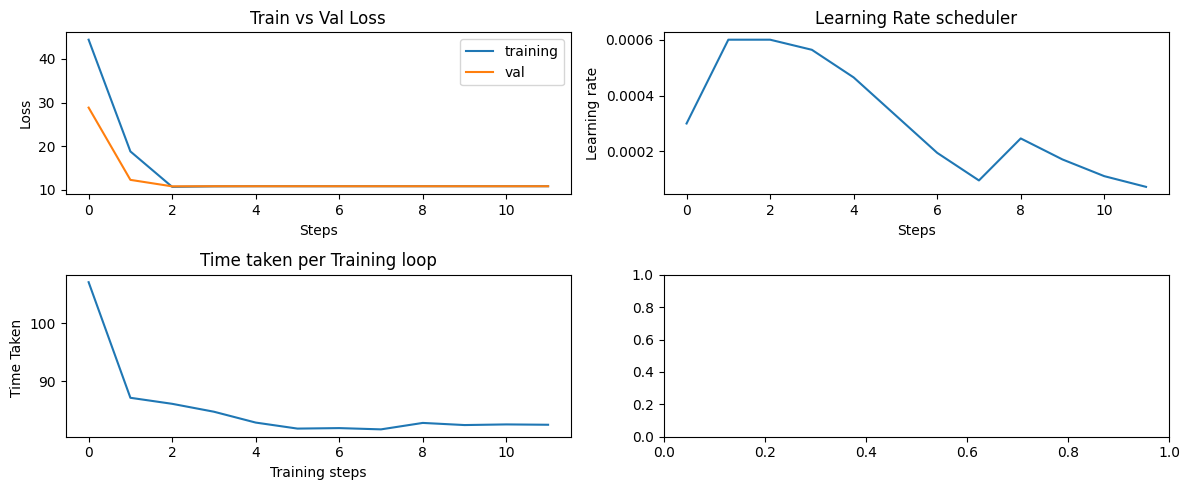

In [31]:
with open("metrics.json","r") as f:
  metrics = json.load(f)

figure,axis = plt.subplots(nrows=2,ncols=2,figsize=(12,5))
axis = axis.flatten()



axis[0].plot(metrics["train_loss"],label="training")
axis[0].plot(metrics["val_loss"],label="val")
axis[0].set_title("Train vs Val Loss")
axis[0].set_xlabel("Steps")
axis[0].set_ylabel("Loss")
axis[0].legend()


axis[1].plot(metrics["learning_rate"])
axis[1].set_title("Learning Rate scheduler")
axis[1].set_xlabel("Steps")
axis[1].set_ylabel("Learning rate")


axis[2].plot(metrics["epoch_times"])
axis[2].set_title("Time taken per Training loop")
axis[2].set_xlabel("Training steps")
axis[2].set_ylabel("Time Taken ")

plt.tight_layout()
plt.show()

# Reload From Checkpoint

In [29]:
import json,time
import logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(message)s",
    handlers=[
        logging.FileHandler("training_logs.txt", mode="a")
    ],
    force=True
)
def load_checkpoint(filename):
    """Load checkpoint and resume training"""
    checkpoint = torch.load(filename, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    scaler.load_state_dict(checkpoint["scaler_state_dict"])
    start_epoch = checkpoint["epoch"]

    print(f"Resumed from epoch {start_epoch}")
    print(f"Checkpoint loaded: {filename}")
    print(f"Previous train loss: {checkpoint['train_loss']:.4f}")
    if checkpoint['val_loss'] is not None:
      print(f"Previous val loss: {checkpoint['val_loss']:.4f}")
    return start_epoch

# ============================= Load Metrics ======================================

def load_metrics(filename="metrics.json"):
    with open(filename, "r") as f:
        metrics = json.load(f)

    # load metrics to rescume checkpoint
    train_loss = metrics.get("train_loss", [])
    val_loss = metrics.get("val_loss", [])
    learning_rate = metrics.get("learning_rate", [])
    epoch_times = metrics.get("epoch_times", [])
    config = metrics.get("config", {})
    return train_loss, val_loss, learning_rate, config, epoch_times

# ================================== Hyperparameter ===================

num_epochs = 12
accum_steps = 4

# ============================ Using above function=============================

# set a flag for stating from scratch or from where left off
resume_from_checkpoint = True # fasle to start from 0
checkpoint_file = "/content/checkpoint_epoch8.pt"

if resume_from_checkpoint:
  # load checkpoint
  start_epoch = load_checkpoint(checkpoint_file)

  # Load metrics
  train_loss,val_loss,learning_rate,config,cycle_times = load_metrics()
  eval_interval = config["eval_interval"]
  warmup_step = config["warmup_epochs"]
  max_lr = config["max_lr"]
  min_lr = config["min_lr"]
  best_val_loss = max(train_loss)


  print(f"Resuming training from epoch {start_epoch+1}")
  for epoch in range(start_epoch,num_epochs):
    epoch_start_time = time.time()
    total_train_loss = 0
    num_batches = 0
    model.train()

    for i in tqdm(range(batches_per_epoch),desc="training"):
      # ================================= Forward + Backward Propogation ==================================================
      xb,yb = train_data.get_batch()

      if device == "cuda":
        with torch.cuda.amp.autocast():
          logits,loss = model(xb,yb)
      else:
          logits,loss = model(xb,yb)
      loss = loss / accum_steps  # normalize the loss as (l1+l2+l3+l4)/4
      scaler.scale(loss).backward()

      total_train_loss +=loss.item() * accum_steps
      num_batches +=1  # increment batch by 1


  # ============================ Gradient Accumulation Updatate ===========================================
      if (i+1) % accum_steps == 0:
        # Unscale gradients before clipping
        scaler.unscale_(optimizer)

        # Gradinet clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) ## help in reducing exploding gradient issue by normalizing them

        # update parameter
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)

      # Handle remaining gradient if batches dont divide evenly by accum_steps
      if num_batches % accum_steps != 0:
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) ## help in reducing exploding gradient issue by normalizing them
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)

  #================================ End of epoch =======================

    # Calculate average training loss for the epoch
    avg_train_loss = total_train_loss / num_batches
    train_loss.append(avg_train_loss)

    # update learning rate per epoch
    lr = get_lr(epoch)
    for param_group in optimizer.param_groups:
      param_group["lr"] = lr
    learning_rate.append(lr)


    # calculate time per epoch
    epoch_duration = time.time() - epoch_start_time
    epoch_times.append(epoch_duration)
  #============================ Evalauaiton ==============

    if (epoch+1) % eval_interval == 0:
      print("Evaluating.....")
      avg_val_loss = loss_calculation(val_data,eval_batches)
      val_loss.append(avg_val_loss)
      logging_msg = (f"Epoch: {epoch+1}/{num_epochs}  |  "
                          f"train_loss: {avg_train_loss:.4f}  |  "
                          f"val_loss: {avg_val_loss:.4f}  |  "
                          f"lr: {lr:.6f}  |  "
                          f"time: {epoch_duration/60:.2f}m")
      logging.info(logging_msg)
      print(logging_msg)


  #====================================== save best model ============
    if avg_val_loss < best_val_loss:
      best_val_loss = avg_val_loss
      torch.save(model.state_dict(),"best_model.pt")
      print(f"New best model saved with {best_val_loss:.2f}")


      # print("="*100)

  #====================================== Checkpointint ===============================
    if (epoch+1) % save_interval == 0:
      current_val_loss = val_loss[-1] if val_loss else None
      save_checkpoint(
            epoch=epoch + 1,
            avg_train_loss=avg_train_loss,
            avg_val_loss=current_val_loss,
            filename=f"checkpoint_epoch{epoch+1}.pt")

    print("="*100)


    #======================== Save Final metrics ===============================
  metrics = {
        "train_loss":train_loss,
        "val_loss":val_loss,
        "learning_rate":learning_rate,
          "epoch_times":epoch_times,
        "config":{
            "num_epochs":num_epochs,
            "eval_interval":eval_interval,
            "warmup_epochs":warmup_epochs,
            "max_lr":max_lr,
            "min_lr":min_lr
        }
    }
  with open("metrics.json","w") as f:
      json.dump(metrics,f,indent=2)

  tqdm.write("\nTraining complete! Metrics saved to metrics.json")

Resumed from epoch 8
Checkpoint loaded: /content/checkpoint_epoch8.pt
Previous train loss: 10.8249
Previous val loss: 10.8249
Resuming training from epoch 9


training: 100%|██████████| 1816/1816 [01:22<00:00, 21.91it/s]


Evaluating.....


Evaluation: 100%|██████████| 120/120 [00:01<00:00, 76.42it/s]


Epoch: 9/12  |  train_loss: 10.8249  |  val_loss: 10.8249  |  lr: 0.000247  |  time: 1.38m
New best model saved with 10.82
Checkpoint saved: checkpoint_epoch9.pt


training: 100%|██████████| 1816/1816 [01:22<00:00, 22.01it/s]


Evaluating.....


Evaluation: 100%|██████████| 120/120 [00:01<00:00, 77.12it/s]


Epoch: 10/12  |  train_loss: 10.8249  |  val_loss: 10.8249  |  lr: 0.000171  |  time: 1.38m
Checkpoint saved: checkpoint_epoch10.pt


training: 100%|██████████| 1816/1816 [01:22<00:00, 21.98it/s]


Evaluating.....


Evaluation: 100%|██████████| 120/120 [00:01<00:00, 76.94it/s]


Epoch: 11/12  |  train_loss: 10.8249  |  val_loss: 10.8249  |  lr: 0.000112  |  time: 1.38m
Checkpoint saved: checkpoint_epoch11.pt


training: 100%|██████████| 1816/1816 [01:22<00:00, 22.00it/s]


Evaluating.....


Evaluation: 100%|██████████| 120/120 [00:01<00:00, 77.04it/s]


Epoch: 12/12  |  train_loss: 10.8249  |  val_loss: 10.8249  |  lr: 0.000073  |  time: 1.38m
Checkpoint saved: checkpoint_epoch12.pt

Training complete! Metrics saved to metrics.json


In [ ]:
print(next(model.parameters()).dtype)

# # Check dtype of each named parameter
# for name, param in model.named_parameters():
#     print(f"{name}: {param.dtype}")

torch.float32


In [ ]:
# save file to drive
!mkdir -p /content/drive/MyDrive/GPT  #create a directery

!cp /content/checkpoint_step4000.pt /content/drive/MyDrive/GPT/
!cp metrics.json /content/drive/MyDrive/GPT/
!cp /content/training_logs.txt /content/drive/MyDrive/GPT/

Perplexity=e^CrossEntropyLoss

Perplexities: [3320297731396.3335, 215998.08817523412, 48875.059638998035, 50218.14105297261, 50256.92918698733, 50257.013861170606, 50257.013861170606, 50257.013861170606, 50257.013861170606, 50257.013861170606, 50257.013861170606, 50257.013861170606]


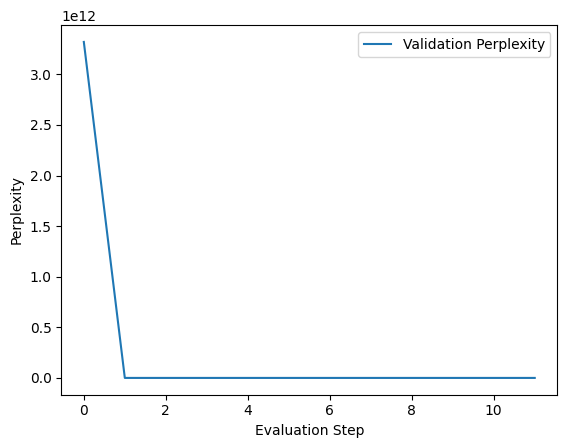

In [30]:
import math
with open("metrics.json","r") as f:
  metrics = json.load(f)

val_losses = metrics["val_loss"]
perplexities = [math.exp(loss) for loss in val_losses]
print("Perplexities:", perplexities)

plt.plot(perplexities, label="Validation Perplexity")
plt.xlabel("Evaluation Step")
plt.ylabel("Perplexity")
plt.legend()
plt.show()


# Generation

In [ ]:
def generate(max_new_token,idx,temperature,top_k=None):
  for _ in range(max_new_token):
    # e.g block size = 4   &  idx = [12, 98, 530, 75, 1001, 58]
    # idx_cond = idx[:, -4:]  ===>  idx_cond[530, 75, 1001, 58]
    idx_cond = idx[:,-config_param.block_size:]
    logits,loss = model(idx_cond)
    logits = logits[:,-1,:]  # we  only take the last token as it is newly generated

    # Apply temperature
    if temperature > 0.0:
      logits = logits / temperature

    #Keep only top_k values
    if top_k is not None:
      top_logits,_ = torch.topk(logits,top_k) #gives top k logits (and their indices) for each batch
      #  cutoff: smallest logit among top-k tokens
      min_val = top_logits[:, -1].unsqueeze(-1)   # (batch_size,)  ==>  (batch_size, vocab_size(1))
      # mask out everything not in top k(min_val)
      logits[logits < min_val] = -float('Inf') # mask out everything below that cutoff with -inf ==> so those tokens never get sampled.

    prob = F.softmax(logits,dim=-1)  #(B,C)
    #idx_next = torch.argmax(prob, dim=-1, keepdim=True) #(deterministic) pick one with higher probability
    idx_next = torch.multinomial(prob, num_samples=1) # it randomy pick any token(Non-deterministic)
    idx = torch.cat((idx,idx_next),dim=1)  # we concatenate the new token with idx which is our input==> we try to complete the sequence
  return idx

user_input = "waht is AI"
encoded_input = enc.encode(user_input)  # encode
tensor_input = torch.tensor(encoded_input,dtype=torch.long).unsqueeze(0) # conver to tensor ==> add batch dimesnion
output = generate(max_new_token=100,idx=tensor_input,temperature=1.2,top_k=4)
decode = enc.decode(output[0].tolist()) # decoder ==> convert tensor to list
print(decode)



# Lower temperature (e.g., 0.7) → more deterministic
# Higher temperature (e.g., 1.2) → more random

waht is AI doer
 man man man man man me man most most man the most man me man man me the man most the me man most man most most man me most most man the most me me the man the the most most me me most man man man man the man me the most most most me most the me man the most me most me most most the the me most most most me most the man me man man man me the most me most the man man man me most most man man man


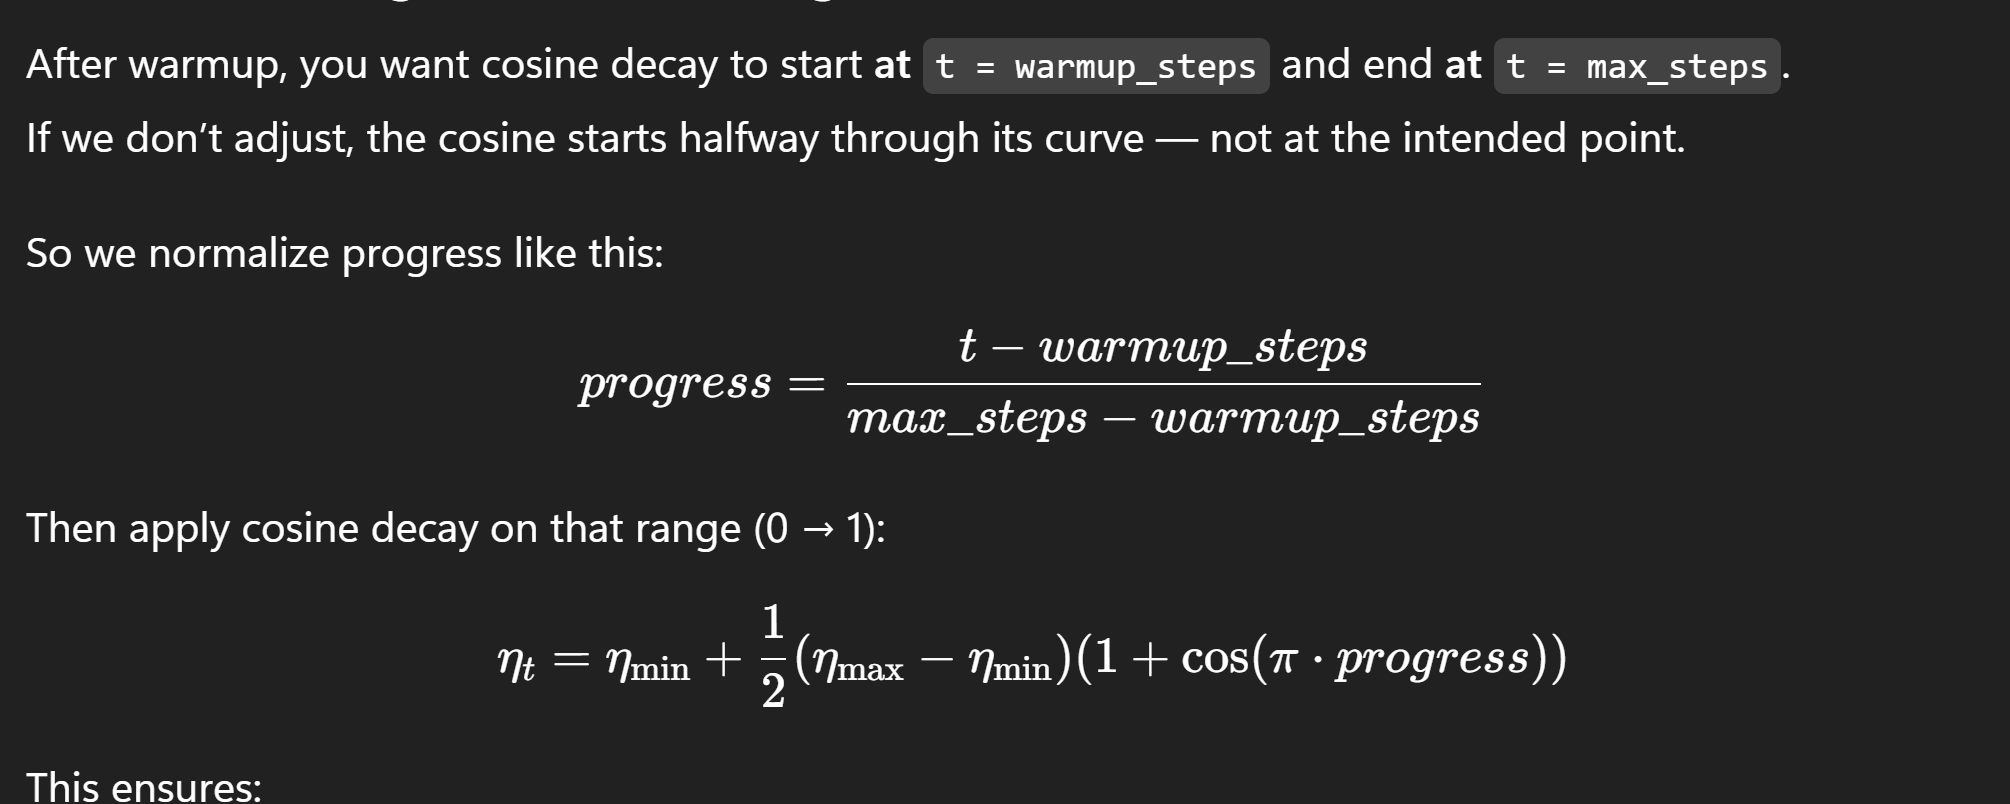

In [ ]:
# learning_rate = []
# train_loss = []
# val_loss = []

# scaler = torch.cuda.amp.GradScaler() # for stable FP16 training(amp=automatic mixed percisoin)
# accum_steps = 50
# eval_interval = 10

# for step in range(max_steps):
#   total_train_loss = 0
#   model.train()

#   for batch_index,(xb,yb) in enumerate(train_loader):
#     # ================================= Forward + Backward Propogation ==================================================
#     if device == "cuda":
#       with torch.cuda.amp.autocast():
#         logits,loss = model(xb,yb)
#     else:
#         logits,loss = model(xb,yb)
#     loss = loss / accum_steps  # normalize the loss as (l1+l2+l3+l4)/4
#     scaler.scale(loss).backward()


# # ============================ Gradient Accumulation Updatate ===========================================
#     if (batch_index+1) % accum_steps == 0:
#       # Unscale gradients before clipping
#       scaler.unscale_(optimizer)

#       # Gradinet clipping
#       torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) ## help in reducing exploding gradient issue by normalizing them

#       # Learning rate scheduler
#       lr = get_lr(step)
#       for param_group in optimizer.param_groups:
#         param_group["lr"] = lr
#       learning_rate.append(lr)

#       # update parameters
#       scaler.step(optimizer)
#       scaler.update()
#       optimizer.zero_grad(set_to_none=True)

#     total_train_loss = total_train_loss + loss.item() * accum_steps
#   avg_train_loss = total_train_loss / len(train_loader)
#   train_loss.append(avg_train_loss)



# #========================================= Evaluation =========================================================
#   # Evaluation
#   if (step+1) % eval_interval ==0:
#     avg_val_loss = loss_calculation(val_loader)
#     val_loss.append(avg_val_loss)

#     print(f"Step: {step+1}  |  train_loss: {avg_train_loss:.3f}  |  val_loss: {avg_val_loss:.3f}")

# step base training pipline

In [ ]:
import json
import logging
import time


logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(message)s",
    handlers=[
        logging.FileHandler("training_logs.txt", mode="a")
    ],
    force=True
)


learning_rate = []
train_loss = []
val_loss = []
cycle_times = []


max_steps = 2000
accum_steps = 4
num_batch_per_step = config_param.batch_size   # batch size

best_val_loss = float("inf")


# ========================================================= Training Loop =================================

print("Starting training...")
cycle_start_time = time.time()
for step in tqdm(range(max_steps),desc="training"):
  total_train_loss = 0
  model.train()

  for i in range(num_batch_per_step):
    # ================================= Forward + Backward Propogation ==================================================
    xb,yb = train_data.get_batch()
    if device == "cuda":
      with torch.cuda.amp.autocast():
        logits,loss = model(xb,yb)
    else:
        logits,loss = model(xb,yb)
    loss = loss / accum_steps  # normalize the loss as (l1+l2+l3+l4)/4
    scaler.scale(loss).backward()


# ============================ Gradient Accumulation Updatate ===========================================
    if (i+1) % accum_steps == 0:
      # Unscale gradients before clipping
      scaler.unscale_(optimizer)

      # Gradinet clipping
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) ## help in reducing exploding gradient issue by normalizing them

      # Learning rate scheduler
      lr = get_lr(step)
      for param_group in optimizer.param_groups:
        param_group["lr"] = lr
      learning_rate.append(lr)

      # update parameters
      scaler.step(optimizer)
      scaler.update()
      optimizer.zero_grad(set_to_none=True)

    total_train_loss = total_train_loss + loss.item() * accum_steps
  avg_train_loss = total_train_loss / num_batch_per_step
  train_loss.append(avg_train_loss)



#========================================= Evaluation =========================================================
  # Evaluation
  if (step+1) % eval_interval ==0:
    # Calcaulating time taken per training cycle
    cycle_duration = time.time() - cycle_start_time
    cycle_times.append(cycle_duration)
    tqdm.write(f"Training cycle till step {step+1} took {cycle_duration/60:.2f} minutes")
    # reset cycle timer for next phase
    cycle_start_time = time.time()

    avg_val_loss = loss_calculation(eval_interval)
    val_loss.append(avg_val_loss)

    logging_msg = f"Step: {step+1}  |  train_loss: {avg_train_loss:.3f}  |  val_loss: {avg_val_loss:.3f}"
    logging.info(logging_msg)
    tqdm.write(logging_msg)


  # =============================== Save Best Model ===========================================

    if avg_val_loss < best_val_loss:
      best_val_loss = avg_val_loss
      torch.save(model.state_dict(), "best_model.pt")
      tqdm.write(f" New best model with loss: {best_val_loss:.2f}, model saved!")

  # =========================== CheckPointing =================
  if (step + 1) % save_interval == 0 or (step + 1) == max_steps:
    current_val_loss = val_loss[-1] if val_loss else None  # get val loss
    save_checkpoint(
        step = step + 1,
        avg_train_loss = avg_train_loss,
        avg_val_loss = current_val_loss,
        filename = f"checkpoint_step{step+1}.pt"
    )


   #======================== Save Final metrics ===============================
  metrics = {
       "train_loss":train_loss,
       "val_loss":val_loss,
       "learning_rate":learning_rate,
        "cycle_times":cycle_times,
       "config":{
           "max_steps":max_steps,
           "eval_interval":eval_interval,
           "warmup_step":warmup_steps,
           "max_lr":max_lr,
           "min_lr":min_lr
       }
   }
  with open("metrics.json","w") as f:
    json.dump(metrics,f,indent=2)

tqdm.write("\nTraining complete! Metrics saved to metrics.json")



# step base reload from checkpoint training pipeline

In [ ]:
import json,time
import logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(message)s",
    handlers=[
        logging.FileHandler("training_logs.txt", mode="a")
    ],
    force=True
)
def load_checkpoint(filename):
    """Load checkpoint and resume training"""
    checkpoint = torch.load(filename, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    scaler.load_state_dict(checkpoint["scaler_state_dict"])
    start_step = checkpoint["step"]

    print(f"Resumed from step {start_step}")
    print(f"Checkpoint loaded: {filename}")
    print(f" Resuming from step {start_step}")
    print(f" Previous train loss: {checkpoint['train_loss']:.4f}")
    if checkpoint['val_loss'] is not None:
      print(f"Previous val loss: {checkpoint['val_loss']:.4f}")
    return start_step

# ============================= Load Metrics ======================================

def load_metrics(filename="metrics.json"):
    with open(filename, "r") as f:
        metrics = json.load(f)

    # Safely load or initialize lists
    train_loss = metrics.get("train_loss", [])
    val_loss = metrics.get("val_loss", [])
    learning_rate = metrics.get("learning_rate", [])
    cycle_times = metrics.get("cycle_times", [])
    config = metrics.get("config", {})

    return train_loss, val_loss, learning_rate, config, cycle_times

# ================================== Hyperparameter ===================

max_steps = 4000
num_batch_per_step = config_param.batch_size  # batch size
accum_steps = 4


# ============================ Using above function=============================

# set a flag for stating from scratch or from where left off
resume_from_checkpoint = True # fasle to start from 0
checkpoint_file = "/content/checkpoint_step3000.pt"

if resume_from_checkpoint:
  # load checkpoint
  start_step = load_checkpoint(checkpoint_file)

  # Load metrics
  train_loss,val_loss,learning_rate,config,cycle_times = load_metrics()
  eval_interval = config["eval_interval"]
  warmup_step = config["warmup_step"]
  max_lr = config["max_lr"]
  min_lr = config["min_lr"]
  best_val_loss = max(train_loss)


  cycle_start_time = time.time()
  # start training
  for step in tqdm(range(start_step, max_steps), desc="training", initial=start_step, total=max_steps):
    start_time = time.time()
    total_train_loss = 0
    model.train()

    for i in range(num_batch_per_step):
      # ================================= Forward + Backward Propogation ==================================================
      xb,yb = train_data.get_batch()
      if device == "cuda":
        with torch.cuda.amp.autocast():
          logits,loss = model(xb,yb)
      else:
          logits,loss = model(xb,yb)
      loss = loss / accum_steps  # normalize the loss as (l1+l2+l3+l4)/4
      scaler.scale(loss).backward()


  # ============================ Gradient Accumulation Updatate ===========================================
      if (i+1) % accum_steps == 0:
        # Unscale gradients before clipping
        scaler.unscale_(optimizer)

        # Gradinet clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) ## help in reducing exploding gradient issue by normalizing them

        # Learning rate scheduler
        lr = get_lr(step)
        for param_group in optimizer.param_groups:
          param_group["lr"] = lr
        learning_rate.append(lr)

        # update parameters
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)

      total_train_loss = total_train_loss + loss.item() * accum_steps
    avg_train_loss = total_train_loss / num_batch_per_step
    train_loss.append(avg_train_loss)

  #========================================= Evaluation =========================================================
    # Evaluation
    if (step+1) % eval_interval ==0:
      # Calcaulating time taken per training cycle
      cycle_duration = time.time() - cycle_start_time
      cycle_times.append(cycle_duration)
      tqdm.write(f"Training cycle till step {step+1} took {cycle_duration/60:.2f} minutes")
      # reset cycle timer for next phase
      cycle_start_time = time.time()

      avg_val_loss = loss_calculation(eval_interval)
      val_loss.append(avg_val_loss)

      logging_msg = f"Step: {step+1}  |  train_loss: {avg_train_loss:.3f}  |  val_loss: {avg_val_loss:.3f}"
      logging.info(logging_msg)
      tqdm.write(logging_msg)


    # =============================== Save Best Model ===========================================

      if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_model.pt")
        tqdm.write(f" New best model with loss: {best_val_loss:.2f}, model saved!")

    # =========================== CheckPointing =================
    if (step + 1) % save_interval == 0 or (step + 1) == max_steps:
      current_val_loss = val_loss[-1] if val_loss else None  # get val loss
      save_checkpoint(
          step = step + 1,
          avg_train_loss = avg_train_loss,
          avg_val_loss = current_val_loss,
          filename = f"checkpoint_step{step+1}.pt"
      )

    #======================== Save Final metrics ===============================
    metrics = {
        "train_loss":train_loss,
        "val_loss":val_loss,
        "learning_rate":learning_rate,
        "cycle_times":cycle_times,
        "config":{
            "max_steps":max_steps,
            "eval_interval":eval_interval,
            "warmup_step":warmup_step,
            "max_lr":max_lr,
            "min_lr":min_lr
        }
    }
    with open("metrics.json","w") as f:
      json.dump(metrics,f,indent=2)

  tqdm.write("\nTraining complete! Metrics saved to metrics.json")

